# All the plots for the MDM paper

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd
import random
from scipy.special import erfinv, erf

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
rda_scratch = '/glade/campaign/collections/rda/scratch/harshah'
catalog_url = 'https://data.rda.ucar.edu/harshah/intake_catalogs/posix/cesm2-lens/rda-cesm2-lens-posix.json'
rda_data    = '/glade/campaign/collections/rda/data/harshah/'
#
tmean_path  = rda_data + 'mdm_data/tmean/'
tmax_path   = rda_data + 'mdm_data/tmax/'
tmin_path   = rda_data + 'mdm_data/tmin/'
############
pi_year  = 1865
eoc_year = 2085
#
doy  = 211
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'

In [5]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)
date
date0     = 'Jul30'

In [6]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number neteoceen 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue

def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [7]:
# calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'year'}
    return (ds * weight).mean(other_dims)

In [8]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk25-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

In [9]:
# Create the client to load the Dashboard
client = Client(cluster)

In [10]:
n_workers = 10
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(29a57848, 'tcp://128.117.208.95:44357', workers=10, threads=10, memory=80.00 GiB)

### GMST

In [11]:
var_name    = 'tmax'
folder_path = tmax_path
det_var     = 'detrended_tmax'
temp_var    = 'TREFHTMX'

In [12]:
# gmst_pi  = global_mean(ds_pi)
# gmst_eoc = global_mean(ds_eoc)
# gmst_pi

In [13]:
# gmsta = gmst_eoc.mean('year') - gmst_pi.mean('year')

## Intra-simulation error

In [15]:
qmdm_gmae_tmax   = xr.open_zarr(tmax_path + 'mdm_intrasimu_gmae_tmax.zarr').mdm_error
qshift_gmae_tmax = xr.open_zarr(tmax_path + 'shift_intrasimu_gmae_tmax.zarr').shift_error
#
qmdm_gmae_tmean   = xr.open_zarr(tmean_path + 'mdm_intrasimu_gmae_tmean.zarr').mdm_error
qshift_gmae_tmean = xr.open_zarr(tmean_path + 'shift_intrasimu_gmae_tmean.zarr').shift_error
#
qmdm_gmae_tmin   = xr.open_zarr(tmin_path + 'mdm_intrasimu_gmae_tmin.zarr').mdm_error
qshift_gmae_tmin = xr.open_zarr(tmin_path + 'shift_intrasimu_gmae_tmin.zarr').shift_error

## Inter-simulation error

In [16]:
average_mdm_mae_tmax   = xr.open_zarr(tmax_path + 'mdm_mae_avg100pairs.zarr').tmax
average_sqdm_mae_tmax  = xr.open_zarr(tmax_path + 'sqdm_mae_avg100pairs.zarr').tmax
average_shift_mae_tmax = xr.open_zarr(tmax_path + 'shift_mae_avg100pairs.zarr').tmax
#
average_mdm_mae_tmean   = xr.open_zarr(tmean_path + 'mdm_mae_avg100pairs.zarr').tmean
average_sqdm_mae_tmean  = xr.open_zarr(tmean_path + 'sqdm_mae_avg100pairs.zarr').tmean
average_shift_mae_tmean = xr.open_zarr(tmean_path + 'shift_mae_avg100pairs.zarr').tmean
#
average_mdm_mae_tmin   = xr.open_zarr(tmin_path + 'mdm_mae_avg100pairs.zarr').tmin
average_sqdm_mae_tmin  = xr.open_zarr(tmin_path + 'sqdm_mae_avg100pairs.zarr').tmin
average_shift_mae_tmin = xr.open_zarr(tmin_path + 'shift_mae_avg100pairs.zarr').tmin

## Inter-model error

In [20]:
cmip6_mdm_mae_tmax    = xr.open_zarr(tmax_path + 'cmip6_mdm_mae_avg380pairs.zarr').tasmax
cmip6_sqdm_mae_tmax   = xr.open_zarr(tmax_path + 'cmip6_sqdm_mae_avg380pairs.zarr').tasmax
cmip6_shift_mae_tmax  = xr.open_zarr(tmax_path + 'cmip6_shift_mae_avg380pairs.zarr').tasmax
#
cmip6_mdm_mae_tmean    = xr.open_zarr(tmean_path + 'cmip6_mdm_mae_avg380pairs.zarr').tas
cmip6_sqdm_mae_tmean   = xr.open_zarr(tmean_path + 'cmip6_sqdm_mae_avg380pairs.zarr').tas
cmip6_shift_mae_tmean  = xr.open_zarr(tmean_path + 'cmip6_shift_mae_avg380pairs.zarr').tas
#
cmip6_mdm_mae_tmin    = xr.open_zarr(tmin_path + 'cmip6_mdm_mae_avg380pairs.zarr').tasmin
cmip6_sqdm_mae_tmin   = xr.open_zarr(tmin_path + 'cmip6_sqdm_mae_avg380pairs.zarr').tasmin
cmip6_shift_mae_tmin  = xr.open_zarr(tmin_path + 'cmip6_shift_mae_avg380pairs.zarr').tasmin

### Plot 6

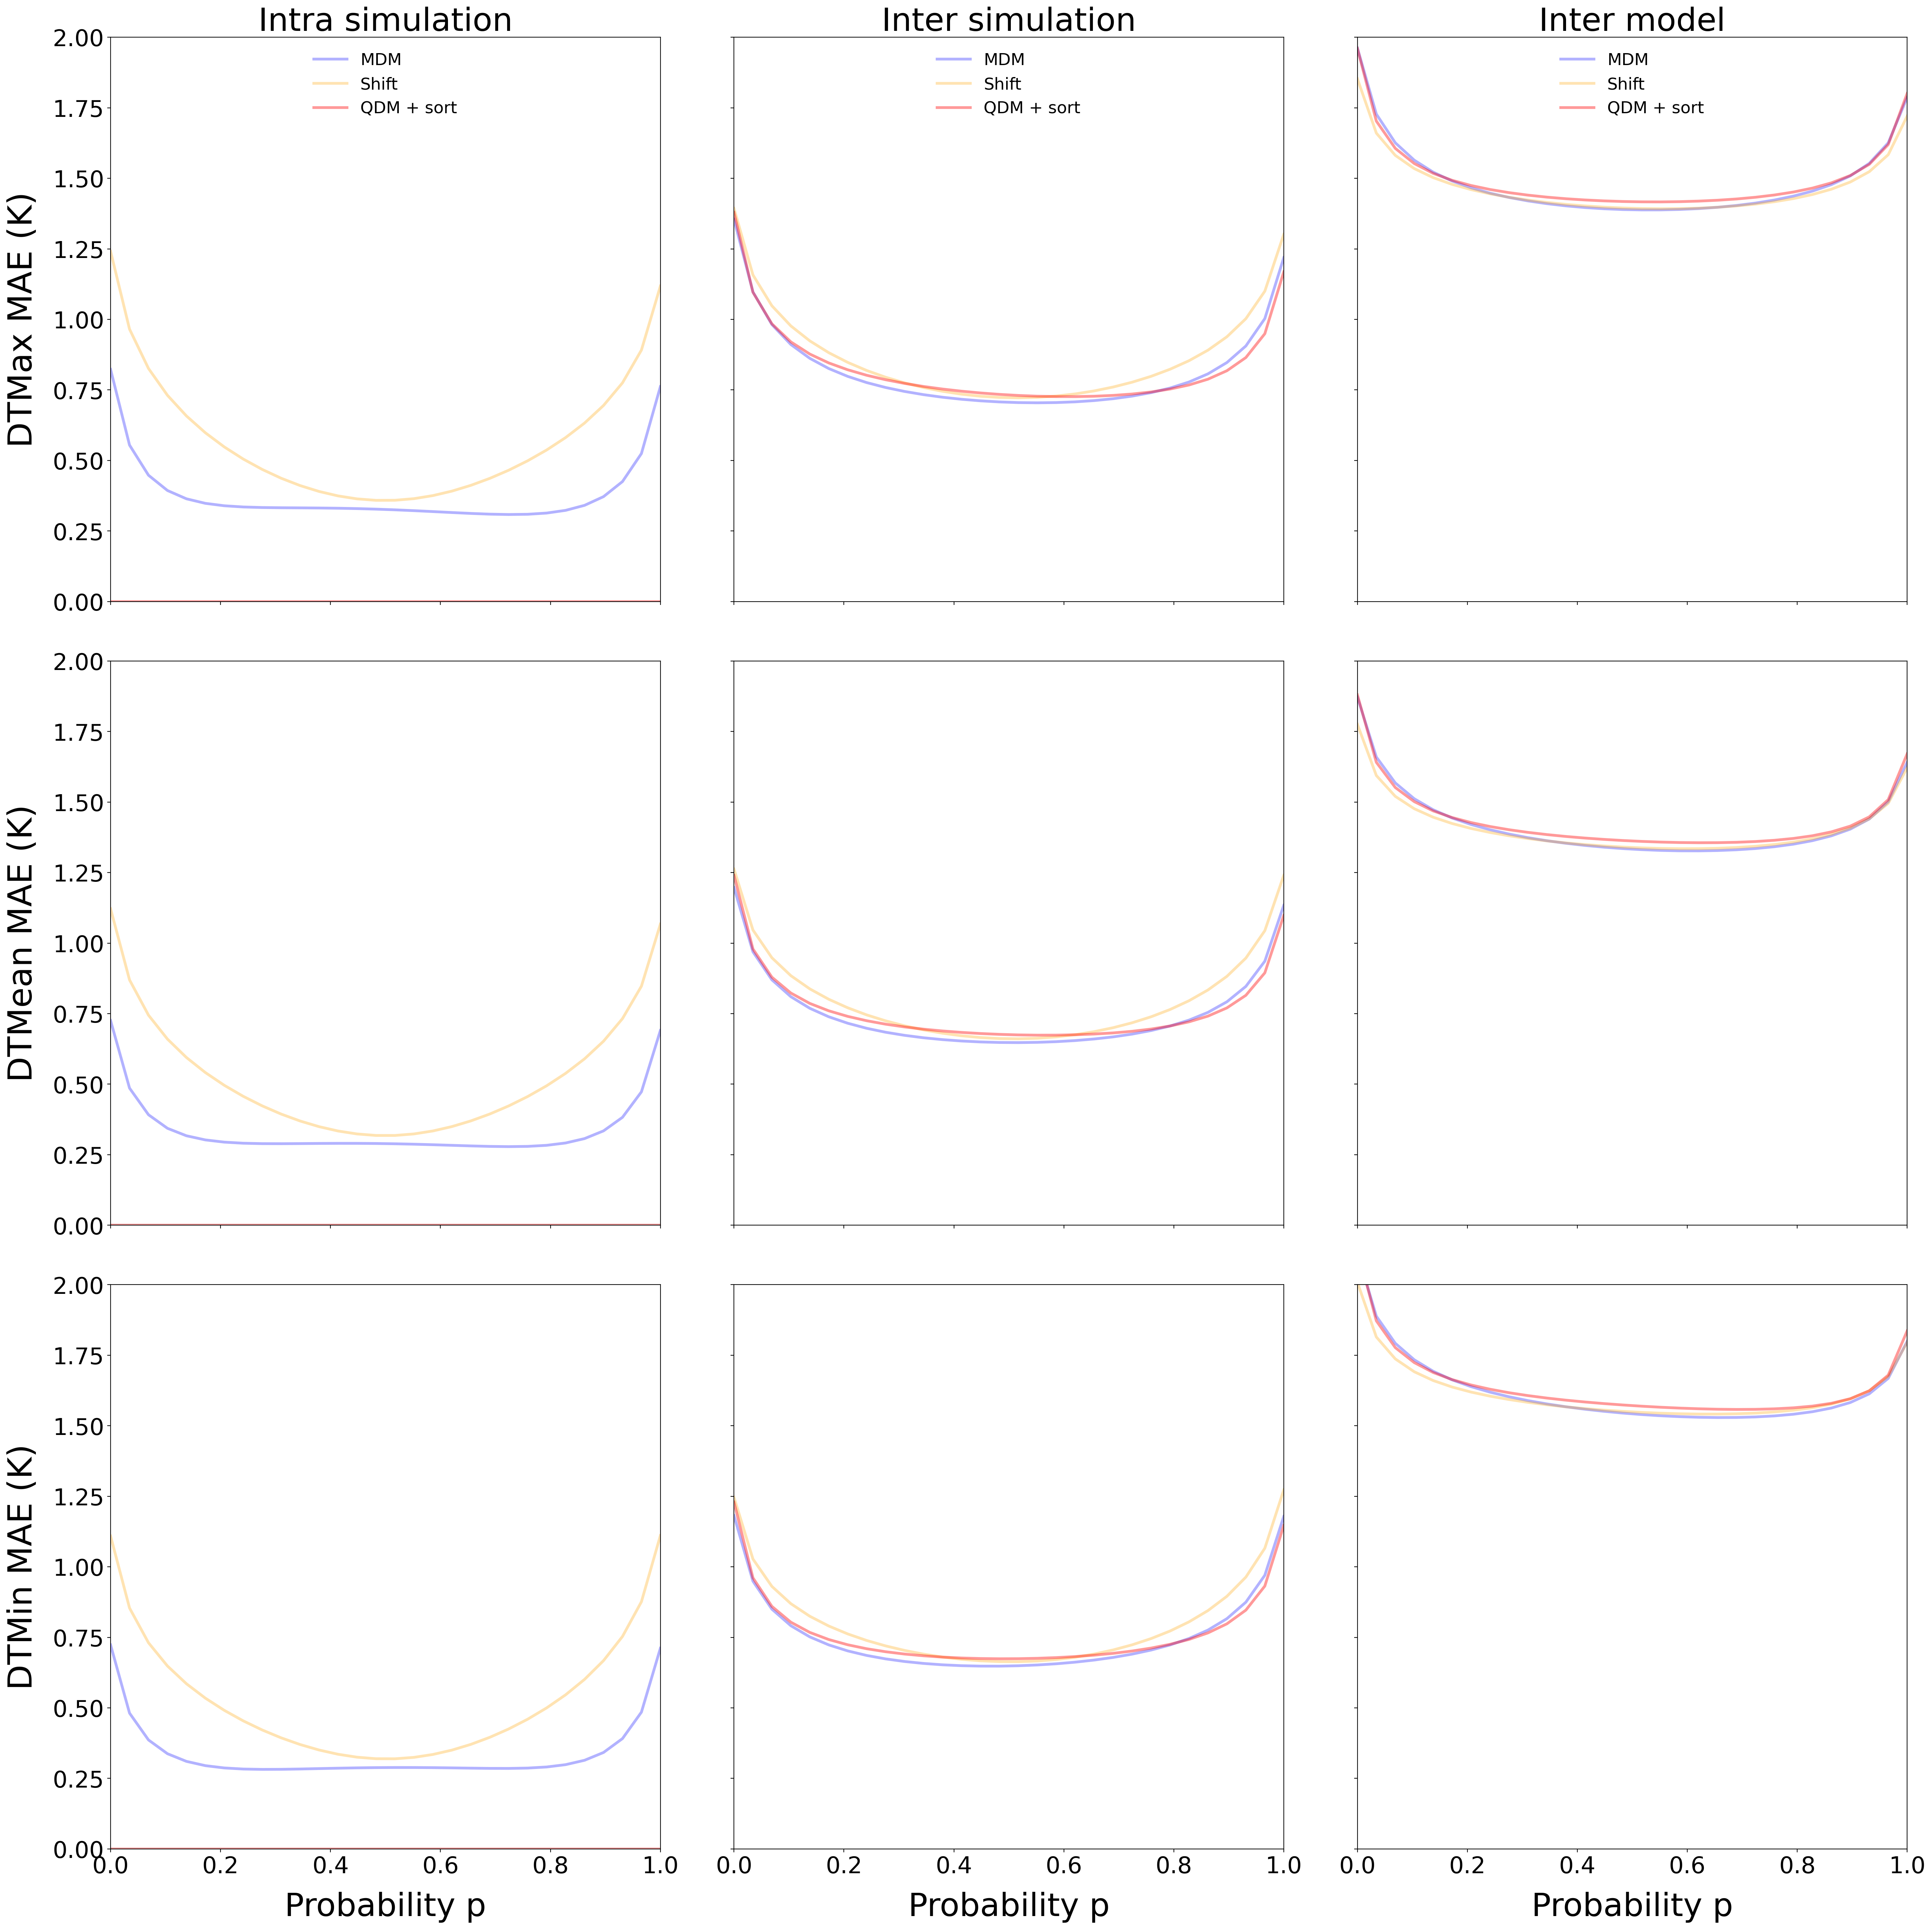

In [27]:
# 30 quantiles
quants30 = np.linspace(0, 1.0, 30)

# Set up 3×3 grid
fig, axs = plt.subplots(3, 3, figsize=(30, 30), sharex='col', sharey='row')

# Column titles
col_titles = ['Intra simulation', 'Inter simulation', 'Inter model']
for j, title in enumerate(col_titles):
    axs[0, j].set_title(title, fontweight=500, fontsize=35)

# Row y-labels
row_labels = ['DTMax MAE (K)', 'DTMean MAE (K)', 'DTMin MAE (K)']
for i, ylab in enumerate(row_labels):
    axs[i, 0].set_ylabel(ylab, fontweight=500, fontsize=36, labelpad=15)

# x-labels only on bottom row
for j in range(3):
    axs[2, j].set_xlabel('Probability p', fontweight=500, fontsize=35, labelpad=15)

# --- Row 0: tmax ---
# Col 0: q-based, with horizontal QDM
axs[0, 0].plot(quants30, qmdm_gmae_tmax,   color='blue',  label='MDM', lw=3, alpha=0.3)
axs[0, 0].plot(quants30, qshift_gmae_tmax, color='orange',label='Shift', lw=3, alpha=0.3)
axs[0, 0].axhline(0, color='red', label='QDM + sort', lw=3, alpha=0.4)
axs[0, 0].legend(loc='upper center', prop={'size':18}, frameon=False)

# Col 1: average-based, with QDM curve
axs[0, 1].plot(quants30, average_mdm_mae_tmax,   color='blue',  label='MDM', lw=3, alpha=0.3)
axs[0, 1].plot(quants30, average_shift_mae_tmax, color='orange',label='Shift', lw=3, alpha=0.3)
axs[0, 1].plot(quants30, average_sqdm_mae_tmax,  color='red',   label='QDM + sort', lw=3, alpha=0.4)
axs[0, 1].legend(loc='upper center', prop={'size':18}, frameon=False)

# Col 2: cmip6-based, with QDM curve
axs[0, 2].plot(quants30, cmip6_mdm_mae_tmax,   color='blue',  label='MDM', lw=3, alpha=0.3)
axs[0, 2].plot(quants30, cmip6_shift_mae_tmax, color='orange',label='Shift', lw=3, alpha=0.3)
axs[0, 2].plot(quants30, cmip6_sqdm_mae_tmax,  color='red',   label='QDM + sort', lw=3, alpha=0.4)
axs[0, 2].legend(loc='upper center', prop={'size':18}, frameon=False)

# --- Row 1: tmean ---
axs[1, 0].plot(quants30, qmdm_gmae_tmean,   color='blue',  label='MDM', lw=3, alpha=0.3)
axs[1, 0].plot(quants30, qshift_gmae_tmean, color='orange',label='Shift', lw=3, alpha=0.3)
axs[1, 0].axhline(0, color='red',          label='QDM + sort', lw=3, alpha=0.4)
#axs[1, 0].legend(loc='upper center', prop={'size':18}, frameon=False)

axs[1, 1].plot(quants30, average_mdm_mae_tmean,   color='blue',  label='MDM', lw=3, alpha=0.3)
axs[1, 1].plot(quants30, average_shift_mae_tmean, color='orange',label='Shift', lw=3, alpha=0.3)
axs[1, 1].plot(quants30, average_sqdm_mae_tmean,  color='red',   label='QDM + sort', lw=3, alpha=0.4)
#axs[1, 1].legend(loc='upper center', prop={'size':18}, frameon=False)

axs[1, 2].plot(quants30, cmip6_mdm_mae_tmean,   color='blue',  label='MDM', lw=3, alpha=0.3)
axs[1, 2].plot(quants30, cmip6_shift_mae_tmean, color='orange',label='Shift', lw=3, alpha=0.3)
axs[1, 2].plot(quants30, cmip6_sqdm_mae_tmean,  color='red',   label='QDM + sort', lw=3, alpha=0.4)
#axs[1, 2].legend(loc='upper center', prop={'size':18}, frameon=False)

# --- Row 2: tmin ---
axs[2, 0].plot(quants30, qmdm_gmae_tmin,   color='blue',  label='MDM', lw=3, alpha=0.3)
axs[2, 0].plot(quants30, qshift_gmae_tmin, color='orange',label='Shift', lw=3, alpha=0.3)
axs[2, 0].axhline(0, color='red',         label='QDM + sort', lw=3, alpha=0.4)
#axs[2, 0].legend(loc='upper center', prop={'size':18}, frameon=False)

axs[2, 1].plot(quants30, average_mdm_mae_tmin,   color='blue',  label='MDM', lw=3, alpha=0.3)
axs[2, 1].plot(quants30, average_shift_mae_tmin, color='orange',label='Shift', lw=3, alpha=0.3)
axs[2, 1].plot(quants30, average_sqdm_mae_tmin,  color='red',   label='QDM + sort', lw=3, alpha=0.4)
#axs[2, 1].legend(loc='upper center', prop={'size':18}, frameon=False)

axs[2, 2].plot(quants30, cmip6_mdm_mae_tmin,   color='blue',  label='MDM', lw=3, alpha=0.3)
axs[2, 2].plot(quants30, cmip6_shift_mae_tmin, color='orange',label='Shift', lw=3, alpha=0.3)
axs[2, 2].plot(quants30, cmip6_sqdm_mae_tmin,  color='red',   label='QDM + sort', lw=3, alpha=0.4)
#axs[2, 2].legend(loc='upper center', prop={'size':18}, frameon=False)

# Common limits and ticks
for i in range(3):
    for j in range(3):
        axs[i, j].set_xlim(0.0, 1.0)
        axs[i, j].set_ylim(0.0, 2.0)
        axs[i, j].tick_params(axis='both', which='major', labelsize=25)

plt.tight_layout(pad=4)
plt.savefig("fig6.pdf", format="pdf", bbox_inches="tight",dpi=600)
plt.show()


In [ ]:
########################################################################

CPU times: user 6.76 s, sys: 317 ms, total: 7.08 s
Wall time: 17.6 s


(0.0, 2.0)

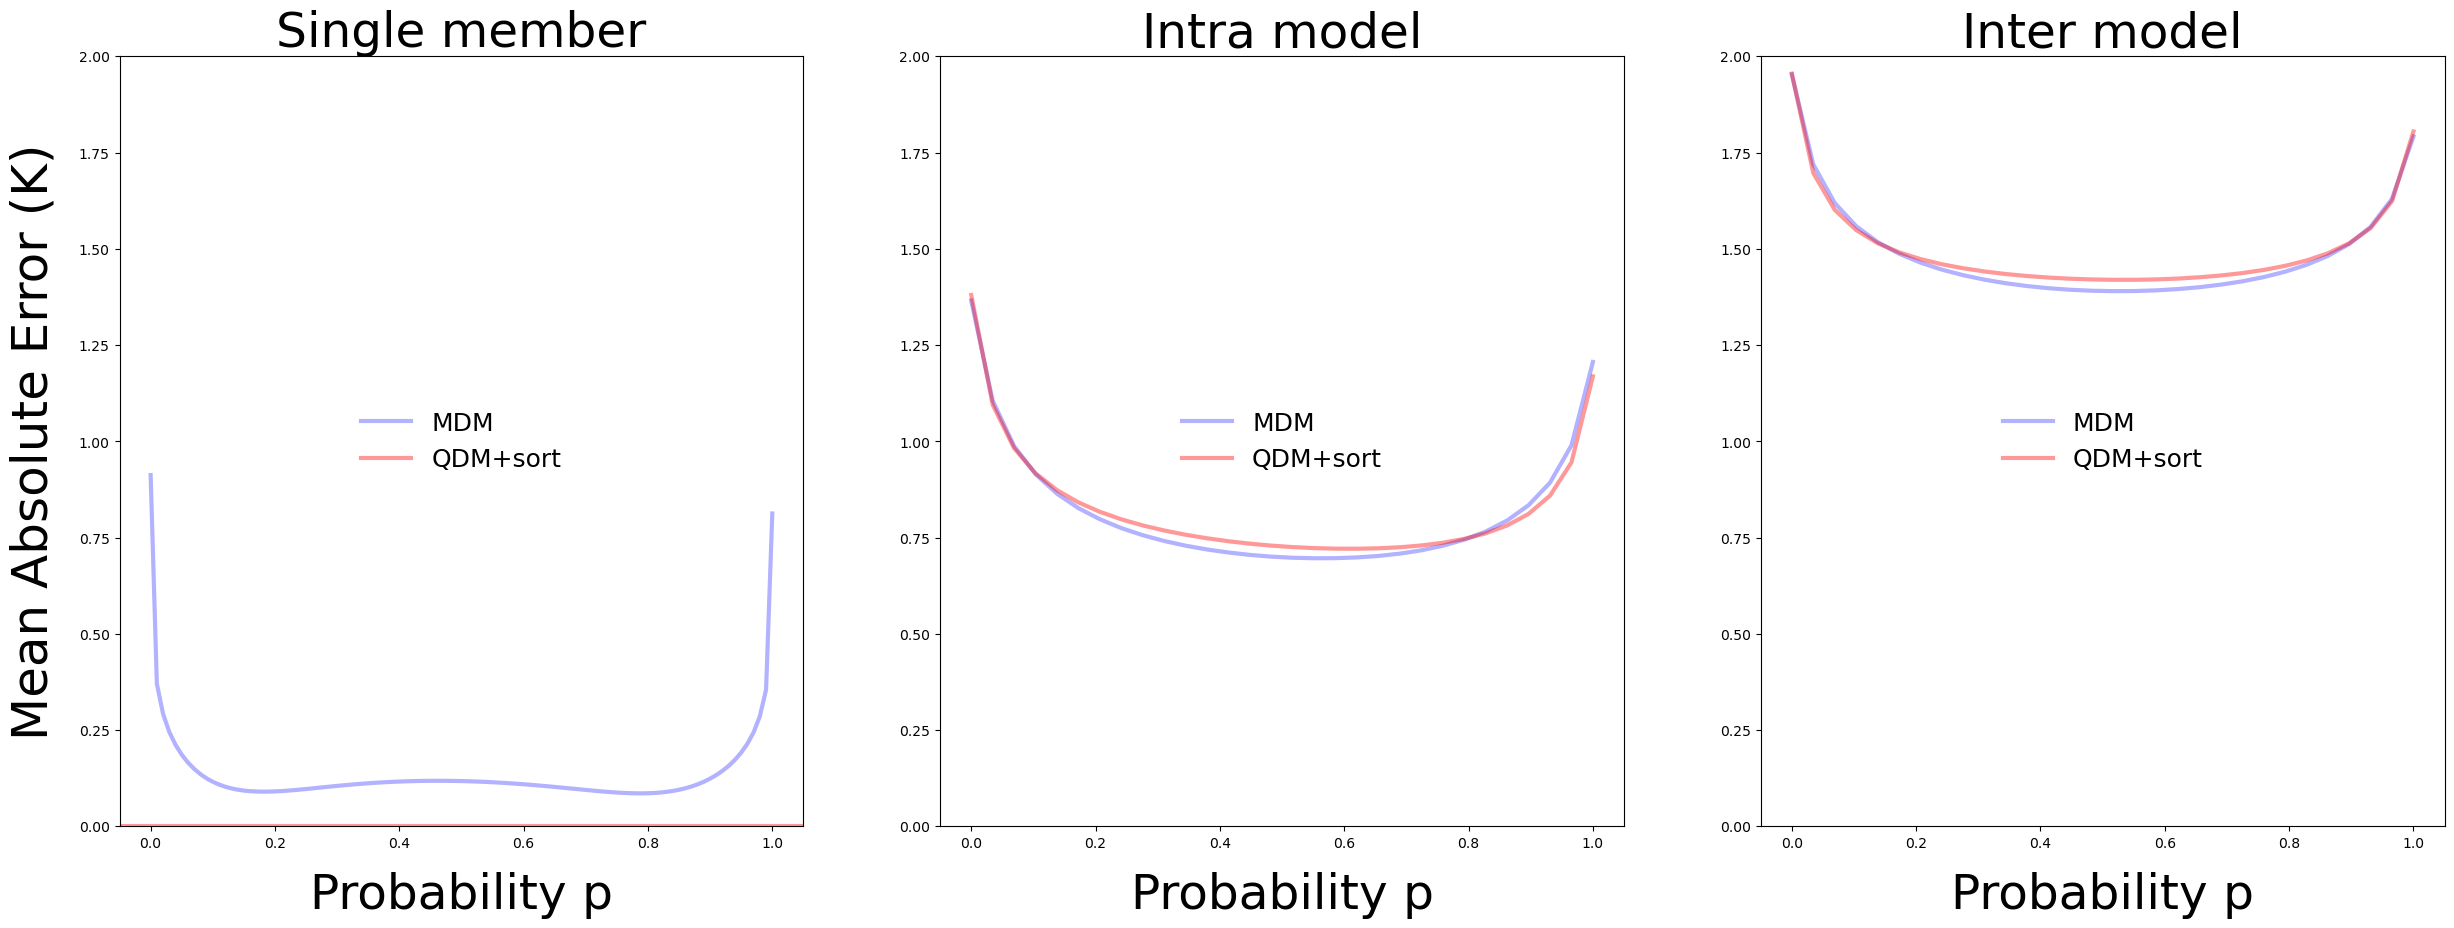

In [28]:
%%time
# Plot the 3 figures as a 3-panel plot
# Setting up the figure and subplots
quants30        = np.linspace(0,1.0,30)
fig, axs = plt.subplots(1, 3, figsize=(30, 10)) # 3 plots - side by side

#Plot for single model
axs[0].plot(quants,qgmsc_gmae,'b', label ='MDM',lw=3,alpha=0.3)
axs[0].axhline(y=0,color='r',label='QDM+sort',lw=3,alpha=0.4)
axs[0].set_ylabel('Mean Absolute Error (K)',fontweight=500,fontsize=36,labelpad=15)
axs[0].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[0].set_title('Intra simulation',fontweight=500,fontsize=35)
axs[0].legend(loc='center',prop={'size': 18},frameon= False)
axs[0].tick_params(axis='both', which='minor', labelsize=20)
axs[0].set_ylim([0.0,2.0])

#Intra model error
axs[1].plot(quants30,average_mdm_mae ,'b', label ='MDM',lw=3,alpha=0.3)
axs[1].plot(quants30,average_sqdm_mae ,'r',label='QDM+sort',lw=3,alpha=0.4)
axs[1].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[1].set_title('Inter simulation',fontweight=500,fontsize=35)
axs[1].legend(loc='center',prop={'size': 18},frameon= False)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].set_ylim([0.0,2.0])

#Inter model error
axs[2].plot(quants30,cmip6_average_mdm_mae ,'b', label ='MDM',lw=3,alpha=0.3)
axs[2].plot(quants30,cmip6_average_sqdm_mae ,'r',label='QDM+sort',lw=3,alpha=0.4)
axs[2].set_xlabel('Probability p',fontweight=400,fontsize=35,labelpad=15)
axs[2].set_title('Inter model',fontweight=400,fontsize=35)
axs[2].legend(loc='center',prop={'size': 18},frameon=False)
axs[2].tick_params(axis='both', which='minor', labelsize=20)
axs[2].set_ylim([0.0,2.0])

In [ ]:
################### Coded until Here #######################

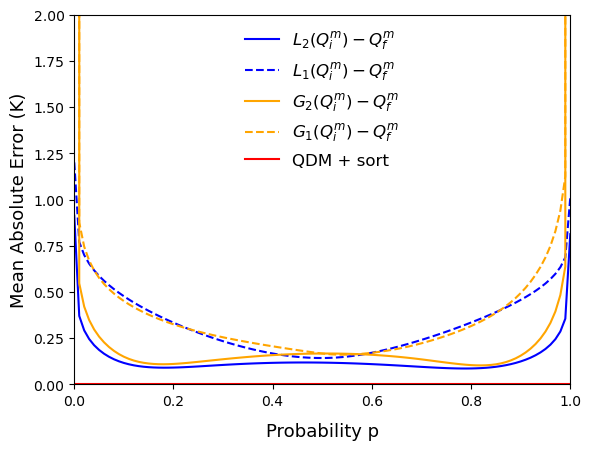

CPU times: user 7.2 s, sys: 411 ms, total: 7.61 s
Wall time: 13.8 s


In [21]:
%%time
plt.plot(quants,qgmsc_gmae,label=r'$L_2(Q_i^m)-Q_f^m$',color='blue')
plt.plot(quants,qgmc_gmae,'--',label = r'$L_1(Q_i^m) - Q_f^m$',color='blue')
plt.plot(quants,qgauss_gmae,label=r'$G_2(Q_i^m) - Q_f^m$',color='orange')
plt.plot(quants,qgaussmo_gmae,'--',label = r'$G_1(Q_i^m) - Q_f^m$',color='orange')
#plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
# specifying horizontal line type 
plt.axhline(y = 0,label = 'QDM + sort', color = 'r') 
plt.legend(loc='upper center',prop={'size':12},frameon=False)
plt.title('')
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,2.0)
plt.show()

In [ ]:
cmip6_average_mdm_mae.values

In [ ]:
cmip6_average_sqdm_mae.values